In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl

In [11]:
quandl.ApiConfig.api_key = 'xDhpuCqGg2q69Ji9jnHs'
stocks = ['AAPL','AMZN','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks, qopts={'columns':['date','ticker','adj_close']}, 
                        date = {'gte':'2016-1-1','lte':'2017-12-31'}, paginate=True)
data

,date,ticker,adj_close
None,,,
0,2017-12-29,FB,176.460000
1,2017-12-28,FB,177.920000
2,2017-12-27,FB,177.620000
3,2017-12-26,FB,175.990000
4,2017-12-22,FB,177.200000
...,...,...,...
1499,2016-01-08,AAPL,93.677776
1500,2016-01-07,AAPL,93.185040
1501,2016-01-06,AAPL,97.291172


In [25]:
df = data.set_index('date')
table = df.pivot(columns='ticker')
table.columns = [col[1] for col in table.columns]
df = table
df

,AAPL,AMZN,FB
date,,,
2016-01-04,101.783763,636.99,102.22
2016-01-05,99.233131,633.79,102.73
2016-01-06,97.291172,632.65,102.97
2016-01-07,93.185040,607.94,97.92
2016-01-08,93.677776,607.05,97.33
...,...,...,...
2017-12-22,175.010000,1168.36,177.20
2017-12-26,170.570000,1176.76,175.99
2017-12-27,170.600000,1182.26,177.62


/var/folders/1q/jjlnxt5j4dg2mnmw35tf858m0000gn/T/ipykernel_16332/1849016547.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


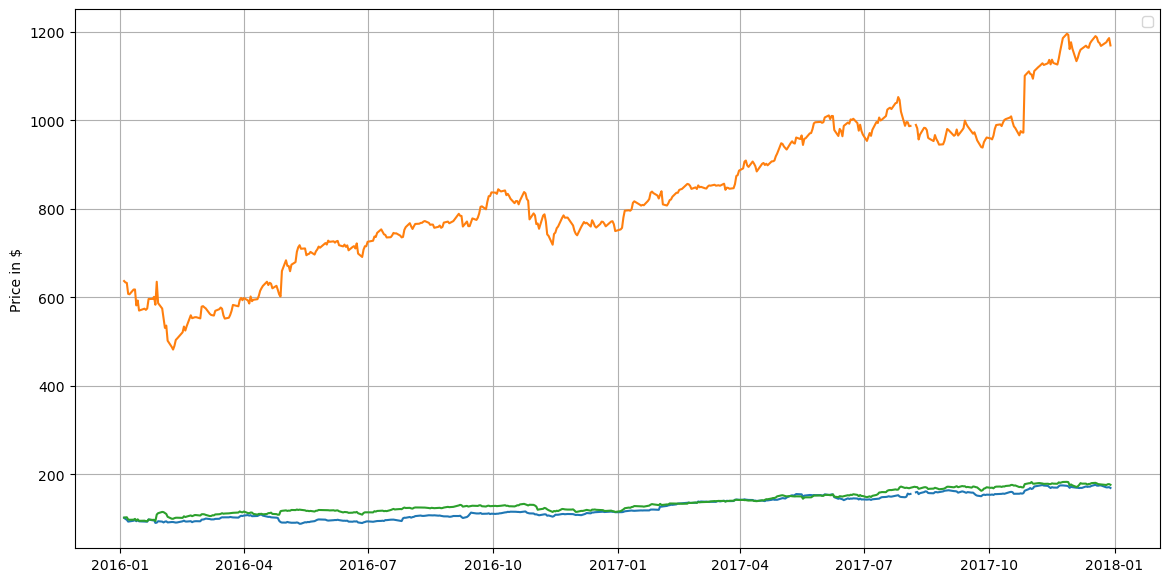

In [42]:
plt.figure(figsize = (14,7))
for stock in df.columns:
    plt.plot(df.index, df[stock])
plt.legend()
plt.ylabel('Price in $')
plt.grid('on')

/var/folders/1q/jjlnxt5j4dg2mnmw35tf858m0000gn/T/ipykernel_16332/3889075871.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df.pct_change()
/var/folders/1q/jjlnxt5j4dg2mnmw35tf858m0000gn/T/ipykernel_16332/3889075871.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


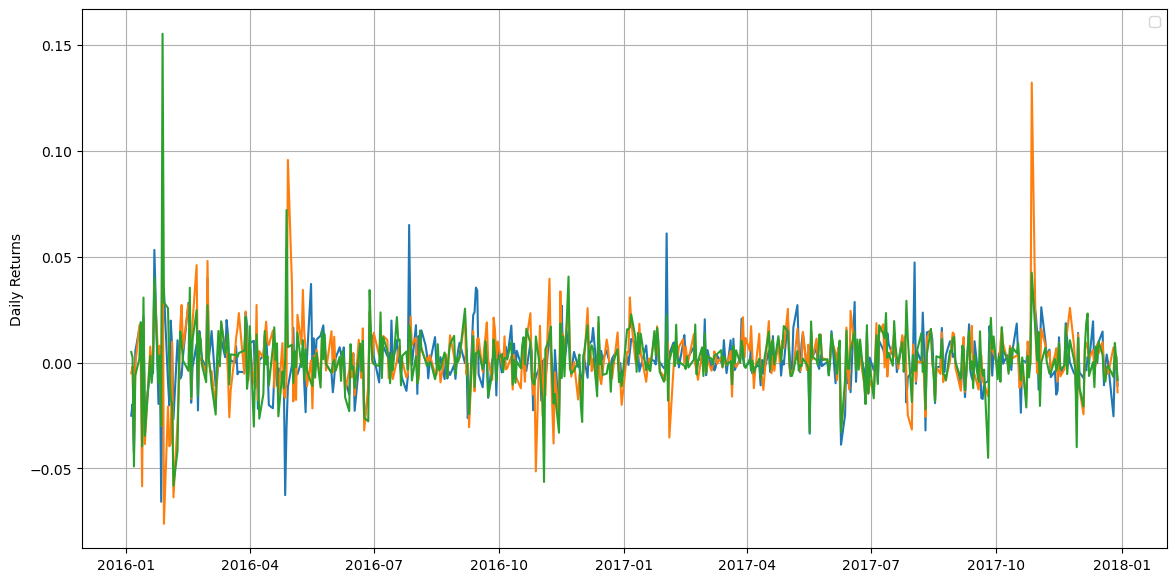

In [56]:
returns = df.pct_change()
plt.figure(figsize = (14,7))
for stock in df.columns:
    plt.plot(df.index, returns[stock])
plt.legend()
plt.ylabel('Daily Returns')
plt.grid('on')

In [76]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [78]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((2,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(3)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
    return results, weights_record

In [80]:
# Sharpe ratio:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(3)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        ## Sharpe Ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev   
    return results, weights_record

In [82]:
returns = table.pct_change()
mean_returns = returns.mean()
print("Mean Returns")
print(mean_returns)
cov_matrix = returns.cov()
print("Covariance Matrix")
print(cov_matrix)
num_portfolios = 25000
risk_free_rate = 0.0178

Mean Returns
AAPL    0.001101
AMZN    0.001340
FB      0.001197
dtype: float64
Covariance Matrix
          AAPL      AMZN        FB
AAPL  0.000171  0.000086  0.000079
AMZN  0.000086  0.000256  0.000142
FB    0.000079  0.000142  0.000217


/var/folders/1q/jjlnxt5j4dg2mnmw35tf858m0000gn/T/ipykernel_16332/3951638528.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = table.pct_change()


In [84]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


             AAPL   AMZN     FB
allocation  44.59  29.07  26.34
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.29
Annualised Volatility: 0.18


             AAPL  AMZN     FB
allocation  54.45  15.8  29.75


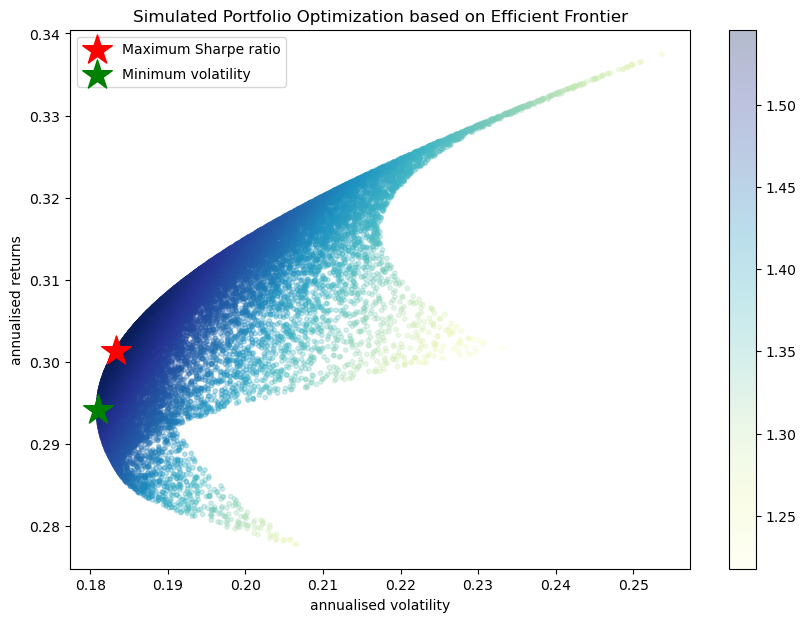

In [86]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


In [ ]:
# Optimisation:
#we have to minimise the negative:

In [ ]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [ ]:
# Minimise volatility:

In [88]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [111]:
print(mean_returns)

AAPL    0.001101
AMZN    0.001340
FB      0.001197
dtype: float64
